In [49]:
import sys
import urllib
import requests
import numpy as np
import pandas as pd
from io import StringIO
from pandas import json_normalize

from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))

from _helpers import to_date_period, to_datetime
# from _elexon_helpers import robust_request
# from build_base import get_bids, get_offers, get_volumes, get_trades
# from build_base import build_physical_notifications_period

date = '2022-01-29'

bdf = pd.read_csv(
    Path.cwd().parent / 'data' / 'base' / f'{date}' / 'bids.csv',
    index_col=[0,1], parse_dates=[0]
).T

odf = pd.read_csv(
    Path.cwd().parent / 'data' / 'base' / f'{date}' / 'offers.csv',
    index_col=[0,1], parse_dates=[0]
).T

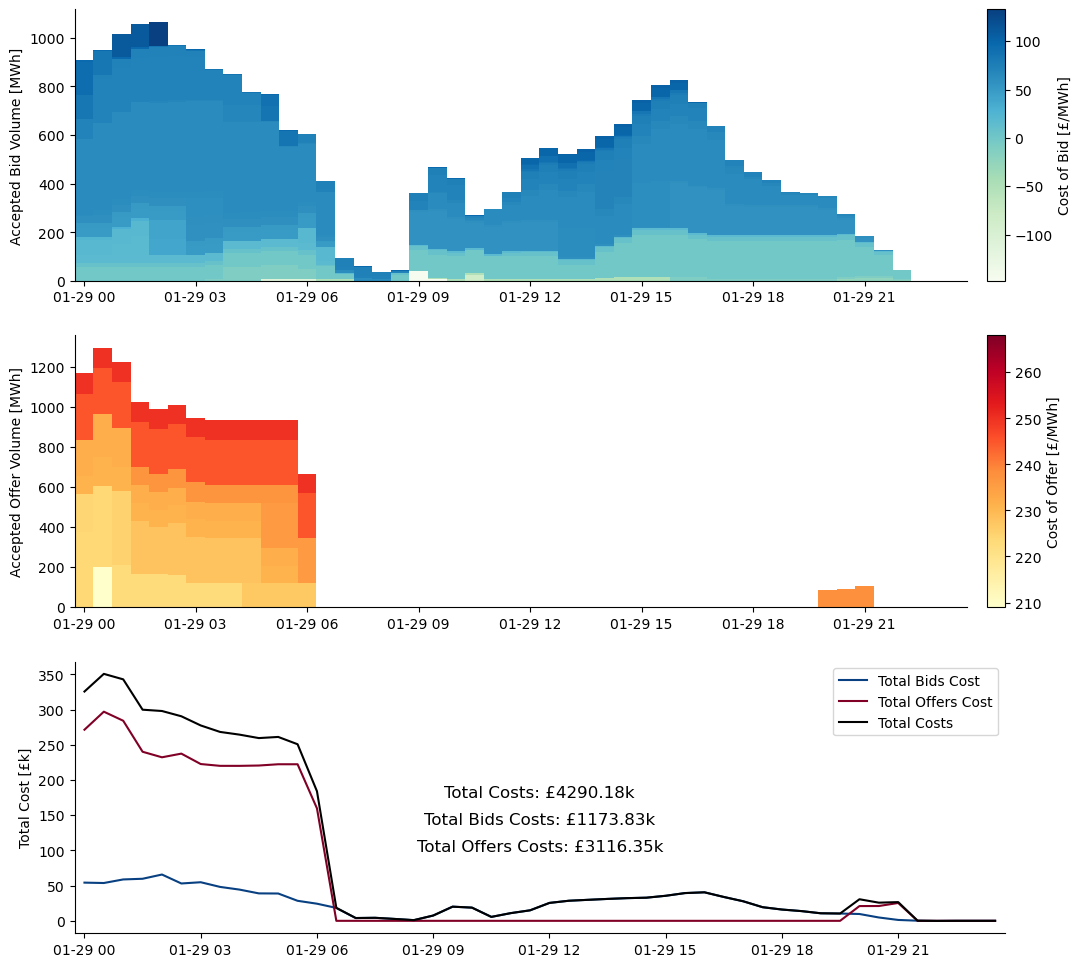

In [50]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = pd.IndexSlice

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

bmin = bdf.loc[:, idx[:, 'price']].min().min()
bmax = bdf.loc[:, idx[:, 'price']].max().max()
bnorm = mcolors.Normalize(vmin=bmin, vmax=bmax)
bmap = plt.cm.GnBu

for i, dt in enumerate(bdf.columns.get_level_values(0).unique()):
    ss = bdf.loc[:, idx[dt, :]].dropna()
    ss.columns = ss.columns.droplevel(0)

    ss = ss.sort_values(by='price')

    ss['cumsum'] = ss['vol'].abs().cumsum()
    
    try:
        ss['cumsum_lower'] = ss['cumsum'] - ss['vol'].iloc[0]
    except IndexError:
        continue

    for _, row in ss.iterrows():
        c = bmap(bnorm(row['price']))
        axs[0].bar(
            dt,
            row['vol'],
            bottom=row['cumsum'] - row['vol'],
            color=c,
            width=1/48,
            )


omin = odf.loc[:, idx[:, 'price']].min().min()
omax = odf.loc[:, idx[:, 'price']].max().max()
onorm = mcolors.Normalize(vmin=omin, vmax=omax)
omap = plt.cm.YlOrRd

for i, dt in enumerate(odf.columns.get_level_values(0).unique()):
    ss = odf.loc[:, idx[dt, :]].dropna()
    ss.columns = ss.columns.droplevel(0)

    ss = ss.sort_values(by='price')

    ss['cumsum'] = ss['vol'].abs().cumsum()

    try:
        ss['cumsum_lower'] = ss['cumsum'] - ss['vol'].iloc[0]
    except IndexError:
        continue

    for _, row in ss.iterrows():
        c = omap(onorm(row['price']))
        axs[1].bar(
            dt,
            row['vol'],
            bottom=row['cumsum'] - row['vol'],
            color=c,
            width=1/48,
            )

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="2%", pad=0.2)

sm = plt.cm.ScalarMappable(cmap=bmap, norm=bnorm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Cost of Bid [£/MWh]')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="2%", pad=0.2)

sm = plt.cm.ScalarMappable(cmap=omap, norm=onorm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Cost of Offer [£/MWh]')


axs[0].set_ylabel('Accepted Bid Volume [MWh]')
axs[1].set_ylabel('Accepted Offer Volume [MWh]')


total_bids_costs = []
total_offers_costs = []

for i, dt in enumerate(bdf.columns.get_level_values(0).unique()):

    bids = bdf.loc[:, idx[dt, :]].dropna()
    bids.columns = bids.columns.droplevel(0)

    offers = odf.loc[:, idx[dt, :]].dropna()
    offers.columns = offers.columns.droplevel(0)

    total_bids_costs.append((bids['vol'] * bids['price']).sum())
    total_offers_costs.append((offers['vol'] * offers['price']).sum())

total_bids_costs = pd.Series(total_bids_costs, index=bdf.columns.get_level_values(0).unique()).mul(1e-3)
total_offers_costs = pd.Series(total_offers_costs, index=odf.columns.get_level_values(0).unique()).mul(1e-3)
total_costs = total_bids_costs + total_offers_costs

axs[2].plot(total_bids_costs.index, total_bids_costs, color=bmap(bnorm(bmax)), label='Total Bids Cost')
axs[2].plot(total_offers_costs.index, total_offers_costs, color=omap(onorm(omax)), label='Total Offers Cost')
axs[2].plot(total_costs.index, total_costs, label='Total Costs', color='black')
axs[2].legend()
axs[2].set_ylabel('Total Cost [£k]')

axs[2].text(0.5, 0.4, 'Total Bids Costs: £{:.2f}k'.format(total_bids_costs.sum()), transform=axs[2].transAxes, fontsize=12, ha='center')
axs[2].text(0.5, 0.3, 'Total Offers Costs: £{:.2f}k'.format(total_offers_costs.sum()), transform=axs[2].transAxes, fontsize=12, ha='center')
axs[2].text(0.5, 0.5, 'Total Costs: £{:.2f}k'.format(total_costs.sum()), transform=axs[2].transAxes, fontsize=12, ha='center')

for ax in axs:

    xmin = bdf.columns.get_level_values(0).min() - pd.Timedelta('15min')
    xmax = bdf.columns.get_level_values(0).max() + pd.Timedelta('15min')

    ax.set_xlim(xmin, xmax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

In [42]:
odf

Empty DataFrame
Columns: [(2022-01-25 00:00:00+00:00, vol), (2022-01-25 00:00:00+00:00, price), (2022-01-25 00:30:00+00:00, vol), (2022-01-25 00:30:00+00:00, price), (2022-01-25 01:00:00+00:00, vol), (2022-01-25 01:00:00+00:00, price), (2022-01-25 01:30:00+00:00, vol), (2022-01-25 01:30:00+00:00, price), (2022-01-25 02:00:00+00:00, vol), (2022-01-25 02:00:00+00:00, price), (2022-01-25 02:30:00+00:00, vol), (2022-01-25 02:30:00+00:00, price), (2022-01-25 03:00:00+00:00, vol), (2022-01-25 03:00:00+00:00, price), (2022-01-25 03:30:00+00:00, vol), (2022-01-25 03:30:00+00:00, price), (2022-01-25 04:00:00+00:00, vol), (2022-01-25 04:00:00+00:00, price), (2022-01-25 04:30:00+00:00, vol), (2022-01-25 04:30:00+00:00, price), (2022-01-25 05:00:00+00:00, vol), (2022-01-25 05:00:00+00:00, price), (2022-01-25 05:30:00+00:00, vol), (2022-01-25 05:30:00+00:00, price), (2022-01-25 06:00:00+00:00, vol), (2022-01-25 06:00:00+00:00, price), (2022-01-25 06:30:00+00:00, vol), (2022-01-25 06:30:00+00:00, price), (2022-01-25 07:00:00+00:00, vol), (2022-01-25 07:00:00+00:00, price), (2022-01-25 07:30:00+00:00, vol), (2022-01-25 07:30:00+00:00, price), (2022-01-25 08:00:00+00:00, vol), (2022-01-25 08:00:00+00:00, price), (2022-01-25 08:30:00+00:00, vol), (2022-01-25 08:30:00+00:00, price), (2022-01-25 09:00:00+00:00, vol), (2022-01-25 09:00:00+00:00, price), (2022-01-25 09:30:00+00:00, vol), (2022-01-25 09:30:00+00:00, price), (2022-01-25 10:00:00+00:00, vol), (2022-01-25 10:00:00+00:00, price), (2022-01-25 10:30:00+00:00, vol), (2022-01-25 10:30:00+00:00, price), (2022-01-25 11:00:00+00:00, vol), (2022-01-25 11:00:00+00:00, price), (2022-01-25 11:30:00+00:00, vol), (2022-01-25 11:30:00+00:00, price), (2022-01-25 12:00:00+00:00, vol), (2022-01-25 12:00:00+00:00, price), (2022-01-25 12:30:00+00:00, vol), (2022-01-25 12:30:00+00:00, price), (2022-01-25 13:00:00+00:00, vol), (2022-01-25 13:00:00+00:00, price), (2022-01-25 13:30:00+00:00, vol), (2022-01-25 13:30:00+00:00, price), (2022-01-25 14:00:00+00:00, vol), (2022-01-25 14:00:00+00:00, price), (2022-01-25 14:30:00+00:00, vol), (2022-01-25 14:30:00+00:00, price), (2022-01-25 15:00:00+00:00, vol), (2022-01-25 15:00:00+00:00, price), (2022-01-25 15:30:00+00:00, vol), (2022-01-25 15:30:00+00:00, price), (2022-01-25 16:00:00+00:00, vol), (2022-01-25 16:00:00+00:00, price), (2022-01-25 16:30:00+00:00, vol), (2022-01-25 16:30:00+00:00, price), (2022-01-25 17:00:00+00:00, vol), (2022-01-25 17:00:00+00:00, price), (2022-01-25 17:30:00+00:00, vol), (2022-01-25 17:30:00+00:00, price), (2022-01-25 18:00:00+00:00, vol), (2022-01-25 18:00:00+00:00, price), (2022-01-25 18:30:00+00:00, vol), (2022-01-25 18:30:00+00:00, price), (2022-01-25 19:00:00+00:00, vol), (2022-01-25 19:00:00+00:00, price), (2022-01-25 19:30:00+00:00, vol), (2022-01-25 19:30:00+00:00, price), (2022-01-25 20:00:00+00:00, vol), (2022-01-25 20:00:00+00:00, price), (2022-01-25 20:30:00+00:00, vol), (2022-01-25 20:30:00+00:00, price), (2022-01-25 21:00:00+00:00, vol), (2022-01-25 21:00:00+00:00, price), (2022-01-25 21:30:00+00:00, vol), (2022-01-25 21:30:00+00:00, price), (2022-01-25 22:00:00+00:00, vol), (2022-01-25 22:00:00+00:00, price), (2022-01-25 22:30:00+00:00, vol), (2022-01-25 22:30:00+00:00, price), (2022-01-25 23:00:00+00:00, vol), (2022-01-25 23:00:00+00:00, price), (2022-01-25 23:30:00+00:00, vol), (2022-01-25 23:30:00+00:00, price)]
Index: []

[0 rows x 96 columns]

In [38]:
bdf.to_csv('bids.csv')

In [39]:
bdf.to_csv('bids.parquet')

In [25]:
viable = bdf.loc[:,idx[:, 'price']].isna().sum(axis=1)

viable = viable.loc[viable < (bdf.shape[1] - 4)].index

In [28]:

print(bdf.loc[viable, idx[:,'price']].mean(axis=1))
m = bdf.loc[viable, idx[:,'price']].mean(axis=1)

print(bdf.loc[viable, idx[:,'price']].std(axis=1))
s = bdf.loc[viable, idx[:,'price']].std(axis=1)

AG-PEDF01    23.7500
AG-ZEN03J    24.0000
BABAW-1      71.5000
BHLAW-1      86.9300
BNWKW-1      93.0000
              ...   
MOWEO-1      82.6700
MOWEO-2      84.5850
MOWEO-3      84.5475
AG-PFLX01    35.0000
PILLB-1      16.2050
Length: 149, dtype: float64
AG-PEDF01    3.535534e+00
AG-ZEN03J    5.163978e+00
BABAW-1      0.000000e+00
BHLAW-1      5.794807e-14
BNWKW-1      0.000000e+00
                 ...     
MOWEO-1      9.970729e+00
MOWEO-2      9.407116e+00
MOWEO-3      1.064957e+01
AG-PFLX01    0.000000e+00
PILLB-1      1.166726e+00
Length: 149, dtype: float64


HAWKB-1      50.611901
WISHB-1      34.916933
BHOLB-1      32.949697
THMRB-1      30.962076
BROAB-1      29.605177
               ...    
AG-HLIM01          NaN
AG-HLIM02          NaN
AG-GSTK05          NaN
AG-HLIM04          NaN
DINO-5             NaN
Length: 149, dtype: float64


<AxesSubplot:ylabel='Frequency'>

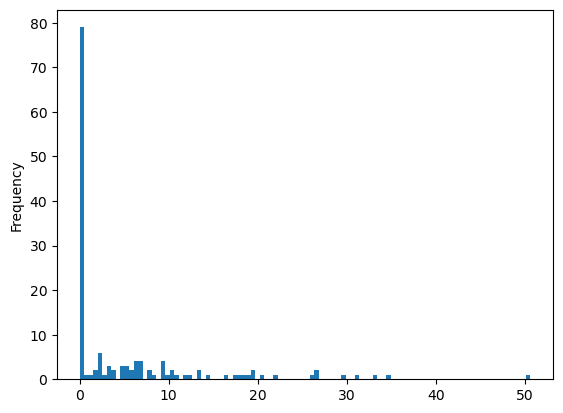

In [33]:
print(s.sort_values(axis=0, ascending=False))
s.plot.hist(bins=100)